In [519]:
import numpy as np

from scipy import linalg as splin

from matplotlib import style
from matplotlib import rcParams
from matplotlib import pyplot as plt

import astropy.units as u
from astropy.coordinates import Angle

In [520]:
## PLOT SETTINGS

style.use('classic')

rcParams['text.usetex'] = True
rcParams.update({'font.size': 14})
rcParams['text.latex.preamble'] = [r'\usepackage{tgheros}']

## Generate Stream of Diracs

The signal $T_0$-periodic signal:
$$x(t) = \sum_{k=1}^K a_k \delta(t-t_k),$$
which has finite rate of innovation. The signal is completely characeterised by the parameters $\{a_k, t_k\}_{k=1}^K$, signal recovery is equivalent to the paraemeter estimation problem.

In [521]:
## GENERATE SIGNAL

np.random.seed(723)

K = 5                                                                       # Number of Diracs
TAU = 1                                                                     # Period of the signal

ak = np.sign(np.random.rand(K))*(1.0 + (np.random.randn(K) - 0.5)/1.0)      # Set amplitudes
tk = np.sort(np.random.rand(K)*TAU)                                         # Set shifts

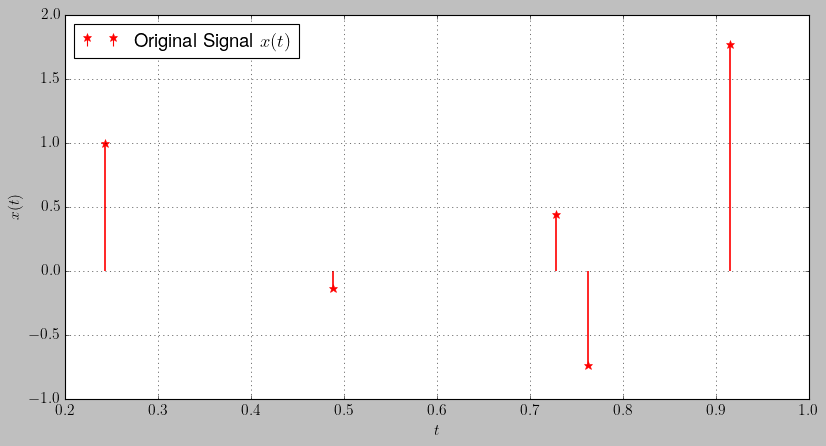

In [522]:
## PLOT ORIGINAL SIGNAL

plt.figure(figsize=(12,6))
markerline211_1, stemlines211_1, baseline211_1 = plt.stem(tk, ak, label=r"Original Signal $x(t)$")
plt.setp(stemlines211_1, linewidth=1.5, color='red')
plt.setp(markerline211_1, marker='*', linewidth=1.5, markersize=8, markerfacecolor='red', mec='red')
plt.setp(baseline211_1, linewidth=0)

plt.grid('on')
plt.legend(loc="upper left")
plt.ylabel(r"$x(t)$")
plt.xlabel(r"$t$")
plt.show()

## Kernel-based Sampling

Let $\varphi$ be the sampling kernel. The filtered signal is sampled to obtain
\begin{equation*}
    y_n = \sum_{k=1}^K a_k \varphi(t'_n - t_k); \; n = 1,\cdots, N.
\end{equation*}


In [523]:
## KERNEL-BASED SAMPLING

def dirichlet(t, B, TAU):
    ''' Returns the Dirichlet kernel evaluated at the point t with bandwidth B'''

    numerator = np.sin(np.pi * B * t)
    denominator = B * TAU * np.sin(np.pi * t / TAU)
    
    idx = np.abs(denominator) < 1e-12
    
    numerator[idx] = np.cos(np.pi * B * t[idx])
    denominator[idx] = np.cos(np.pi * t[idx] / TAU)
    return numerator / denominator

# Define sampling parameters
M = K                           # Number of Fourier measurements
B = (2. * M + 1)/TAU            # Bandwidth of the Dirichlet kernel
N = 2 * M + 1                   # Number of temporal samples

# Filtered signal
t_continuous = np.linspace(0,TAU,1000)
tl_grid, tk_grid = np.meshgrid(tk, t_continuous)
filtered_signal = np.inner(ak, dirichlet(tk_grid - tl_grid, B, TAU))

# Temporal samples
t_unif = np.arange(0, N, dtype=float)*TAU/N
tl_grid, tk_grid = np.meshgrid(tk, t_unif)
samples_unif = np.inner(ak, dirichlet(tk_grid - tl_grid, B, TAU))

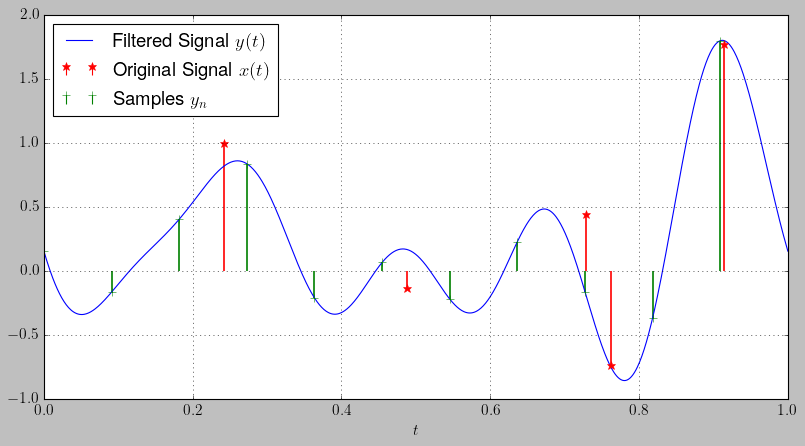

In [524]:
## PLOT FILTERED SIGNAL AND SAMPLES

plt.figure(figsize=(12,6))

# Continous signal
plt.plot(t_continuous, filtered_signal, label=r"Filtered Signal $y(t)$")

# Original signal
markerline211_1, stemlines211_1, baseline211_1 = plt.stem(tk, ak, label=r"Original Signal $x(t)$")
plt.setp(stemlines211_1, linewidth=1.5, color='red')
plt.setp(markerline211_1, marker='*', linewidth=1.5, markersize=8, markerfacecolor='red', mec='red')
plt.setp(baseline211_1, linewidth=0)

# Temporal samples
markerline211_1, stemlines211_1, baseline211_1 = plt.stem(t_unif, samples_unif, label=r"Samples $y_n$")
plt.setp(stemlines211_1, linewidth=1.5, color='green')
plt.setp(markerline211_1, marker='+', linewidth=1.5, markersize=8, markerfacecolor='green', mec='green')
plt.setp(baseline211_1, linewidth=0)

plt.xlabel(r"$t$")
plt.grid('on')
plt.legend(loc="upper left")
plt.show()

## Parameter Estimation using Prony's Method


In [525]:
## FUNCTION DEFINITION :: PRONY'S METHOD

def total_least_squares_Prony(swce, model_order):

    N = swce.size
    M = int(N // 2)

    index_i = -M + model_order + np.arange(1, N - model_order + 1) - 1
    index_j = np.arange(1, model_order + 2) - 1
    index_ij = index_i[:, None] - index_j[None, :]
    conv_mtx = swce[index_ij + M]

    _, _, vh = splin.svd(conv_mtx, check_finite=False, full_matrices=False)
    annihilating_filter = vh[-1, :].conj()
    annihilating_filter = annihilating_filter.reshape(-1)

    return annihilating_filter

In [526]:
## PRONY'S METHOD

# Compute Fourier-series coefficients
forward_matrix = np.exp(1j*2*np.pi*np.outer(t_unif, np.arange(-K,K+1))/TAU)
fourier_series_coeffs = np.linalg.solve(forward_matrix, samples_unif)

# Estimate delays using Prony's method
annihilating_filter = total_least_squares_Prony(fourier_series_coeffs, K)

roots = np.roots(np.flip(annihilating_filter, axis=0).reshape(-1))
locations = Angle(np.angle(roots) * u.rad)
locations = locations.wrap_at(2 * np.pi * u.rad)
tk_estimate = np.sort(TAU * locations.value.reshape(-1) / (2 * np.pi))


# Estimate amplitudes using linear least-squares
swce_matrix = np.exp(-1j*2*np.pi*np.outer(np.arange(-K,K+1), tk_estimate)/TAU)
ak_estimate = N * np.matmul(np.linalg.pinv(swce_matrix),fourier_series_coeffs)

In [527]:
## COMPUTE ERRORS IN ESTIMATION

delay_estimation = np.linalg.norm(tk-tk_estimate)
amplitude_estimation = np.linalg.norm(ak-ak_estimate)

print(r'Total error in delay estimation: {0:.2e}'.format(delay_estimation))
print(r'Total error in amplitude estimation: {0:.2e}'.format(amplitude_estimation))

Total error in delay estimation: 6.48e-16
Total error in amplitude estimation: 7.54e-15


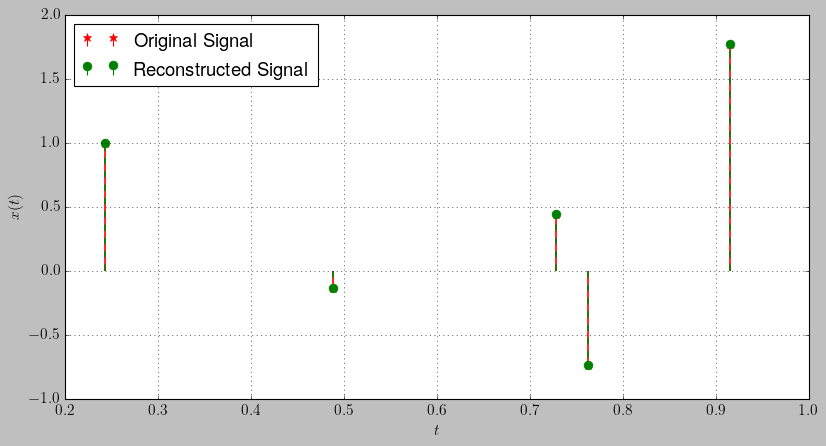

In [528]:
## PLOT RECONSTRUCTED SIGNAL

plt.figure(figsize=(12,6))

# Original signal
markerline211_1, stemlines211_1, baseline211_1 = plt.stem(tk, ak, label=r"Original Signal")
plt.setp(stemlines211_1, linewidth=1.5, color='red')
plt.setp(markerline211_1, marker='*', linewidth=1.5, markersize=8, markerfacecolor='red', mec='red')
plt.setp(baseline211_1, linewidth=0)

# Reconstruction
markerline211_1, stemlines211_1, baseline211_1 = plt.stem(tk_estimate, ak_estimate, '--', label=r"Reconstructed Signal")
plt.setp(stemlines211_1, linewidth=1.5, color='green')
plt.setp(markerline211_1, marker='o', linewidth=1.5, markersize=8, markerfacecolor='green', mec='green')
plt.setp(baseline211_1, linewidth=0)

plt.grid('on')
plt.legend(loc="upper left")
plt.ylabel(r"$x(t)$")
plt.xlabel(r"$t$")
plt.show()